<a href="https://colab.research.google.com/github/namigabbasov/ai-literacy-bibliometric-analysis/blob/main/scripts/python_collaboration_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RQ2 — Knowledge Creation and Collaboration**

Who are the central and productive authors, communities, and countries in AI literacy research, and how do they collaborate?

## Setup: Install and Import Required Libraries

In [1]:
!pip install -q python-louvain networkx matplotlib seaborn pandas numpy pycountry
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
import re
import community as community_louvain  # python-louvain
import pycountry
from itertools import combinations
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import community.community_louvain as community_louvain

import re, pandas as pd, numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import combinations
import community.community_louvain as community_louvain
import seaborn as sns
sns.set(style="whitegrid")


##

## Load AI Literacy Dataset from GitHub

In [2]:
url = "https://raw.githubusercontent.com/namigabbasov/ai-literacy-bibliometric-analysis/refs/heads/main/data/ai_literacy.csv"
df = pd.read_csv(url, low_memory=False)

In [3]:

### Top authors & productivity patterns

### Normalize Year (Year_int)
if 'Year_int' not in df.columns:
    if 'Year' in df.columns:
        df['Year_int'] = pd.to_numeric(df['Year'], errors='coerce').astype('Int64')
    else:
        df['Year_int'] = pd.NA

### Build authors_list
re_split_seps = re.compile(r'\s*;\s*|\s*\|\s*|\s*\/\s*')

def split_to_list(s):
    if not s or pd.isna(s):
        return []
    s = str(s).strip().replace(" and ", ";")
    parts = [p.strip() for p in re_split_seps.split(s) if p.strip()]
    seen, clean = set(), []
    for p in parts:
        p2 = re.sub(r'\s+', ' ', p)
        if p2 and p2 not in seen:
            seen.add(p2)
            clean.append(p2)
    return clean

df['authors_list'] = df['Authors'].astype(str).apply(split_to_list)

if 'Author full names' in df.columns:
    df['author_fullnames_list'] = df['Author full names'].astype(str).apply(split_to_list)
    def choose_authors(row):
        fulls = row['author_fullnames_list']
        short = row['authors_list']
        if fulls and len(fulls) >= 1 and (len(fulls) == len(short) or len(short) == 0):
            return fulls
        return short
    df['authors_list'] = df.apply(choose_authors, axis=1)

df['authors_list'] = df['authors_list'].apply(lambda lst: [a.strip() for a in lst if a and str(a).strip()])

### Count authors
authors_exploded = df.explode('authors_list')
authors_exploded = authors_exploded[
    authors_exploded['authors_list'].notna() & (authors_exploded['authors_list']!="")
]

author_counts = (
    authors_exploded['authors_list']
    .value_counts()
    .rename_axis('Author')
    .reset_index(name='Publications')
)
print("Top authors (by # publications):")
display(author_counts.head(25))

Top authors (by # publications):


Author  Publications
0                                       nan            51
1            Ng, Tsz Kit Davy (57222469979)            25
2             Kong, Siu Cheung (7203044800)            22
3         Breazeal, Cynthia L. (7003691791)            20
4           Chiu, Thomas K.F. (56435413000)            20
5                  Long, Duri (57195131855)            16
6                 Su, Jiahong (57443505800)            16
7          Chu, Samuel Kai Wah (9943688000)            14
8             Chai, Ching Sing (7201358969)            13
9            Magerko, Brian S. (6506227997)            11
10              Lee, Irene A. (37049104500)            10
11          Velander, Johanna (58414124000)             9
12          Leung, Jac Ka Lok (57207991196)             9
13        Ali, Safinah Arshad (57207448534)             9
14                   Dai, Yun (56576995200)             9
15         Schleiss, Johannes (57219504280)             9
16              Zhou, Xiaofei (57217589045)             9
17          DiPaola, Daniella (57208863454)             9
18          Ognibene, Dimitri (14834121900)             8
19           Yang, Yin Nicole (57213187932)             8
20  Laupichler, Matthias Carl (57907367900)             8
21          Milrad, Marcelo F. (6507974606)             8
22  Petersen, Marianne Graves (56220251300)             8
23  Bilstrup, Karl Emil Kjaer (57218863375)             8
24            Hammer, Jessica (56597500700)             8

/tmp/ipython-input-3858066195.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Publications', y='Author', data=top_authors, palette='viridis')


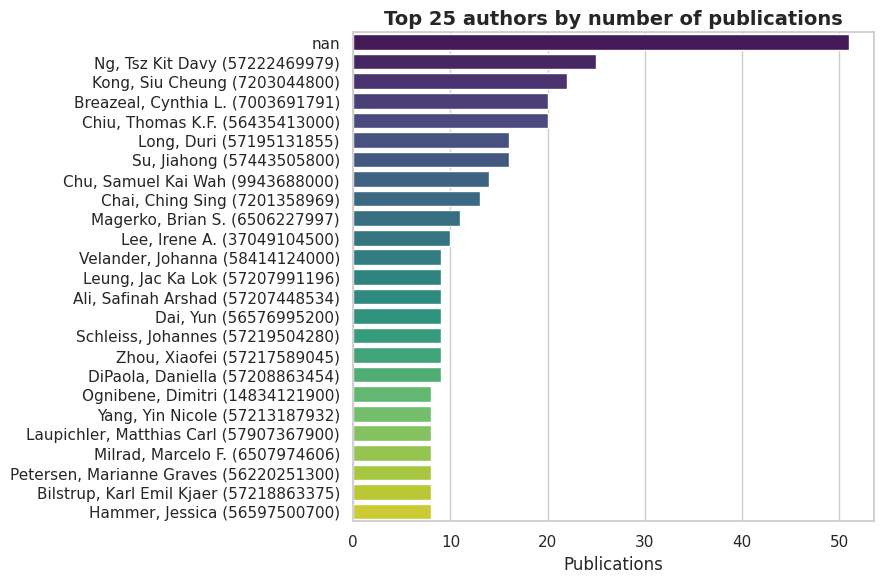

In [4]:
### Plot top N authors bar chart
TOP_N = 25
top_authors = author_counts.head(TOP_N).copy()
plt.figure(figsize=(9,6))
sns.barplot(x='Publications', y='Author', data=top_authors, palette='viridis')
plt.title(f"Top {TOP_N} authors by number of publications", fontsize=14, weight='bold')
plt.xlabel("Publications")
plt.ylabel("")
plt.tight_layout()
plt.show()

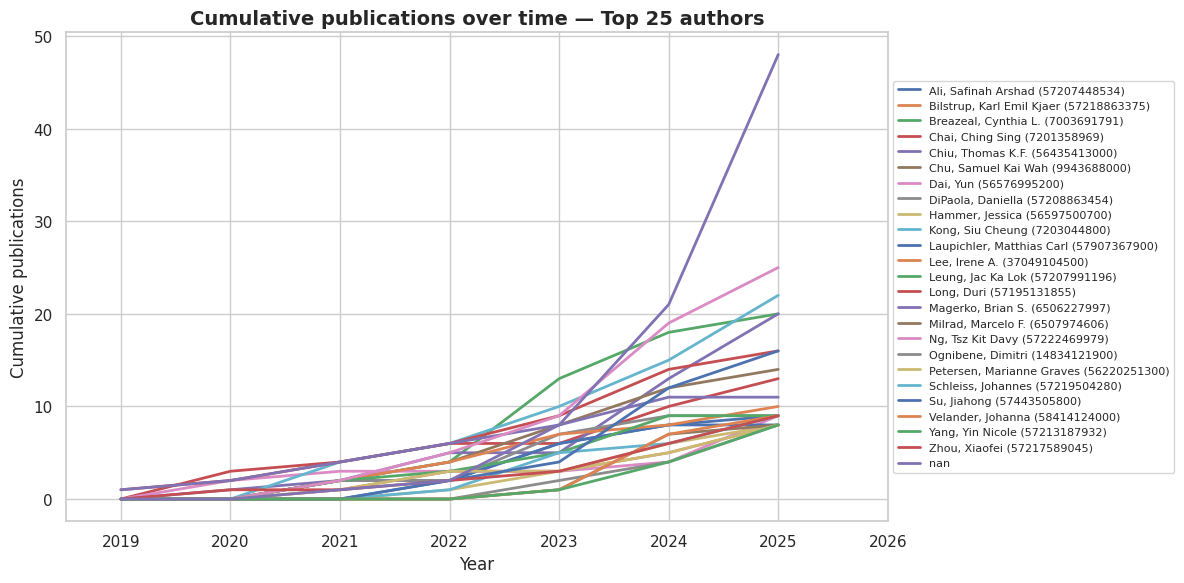

In [5]:
### Author trajectories
ts = authors_exploded[authors_exploded['authors_list'].isin(top_authors['Author'])].copy()
if 'Year_int' in ts.columns:
    ts = ts[ts['Year_int'].notna()]

ts_counts = ts.groupby(['authors_list','Year_int']).size().reset_index(name='count')

if not ts_counts.empty:
    ts_pivot = ts_counts.pivot(index='Year_int', columns='authors_list', values='count').fillna(0).sort_index()
    ts_cum = ts_pivot.cumsum()

    plt.figure(figsize=(12,6))
    for col in ts_cum.columns:
        plt.plot(ts_cum.index, ts_cum[col], linewidth=2, label=col)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
    plt.xlim(ts_cum.index.min()-0.5, ts_cum.index.max()+1)
    plt.xlabel("Year")
    plt.ylabel("Cumulative publications")
    plt.title(f"Cumulative publications over time — Top {TOP_N} authors", fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No yearly data available to plot author trajectories.")


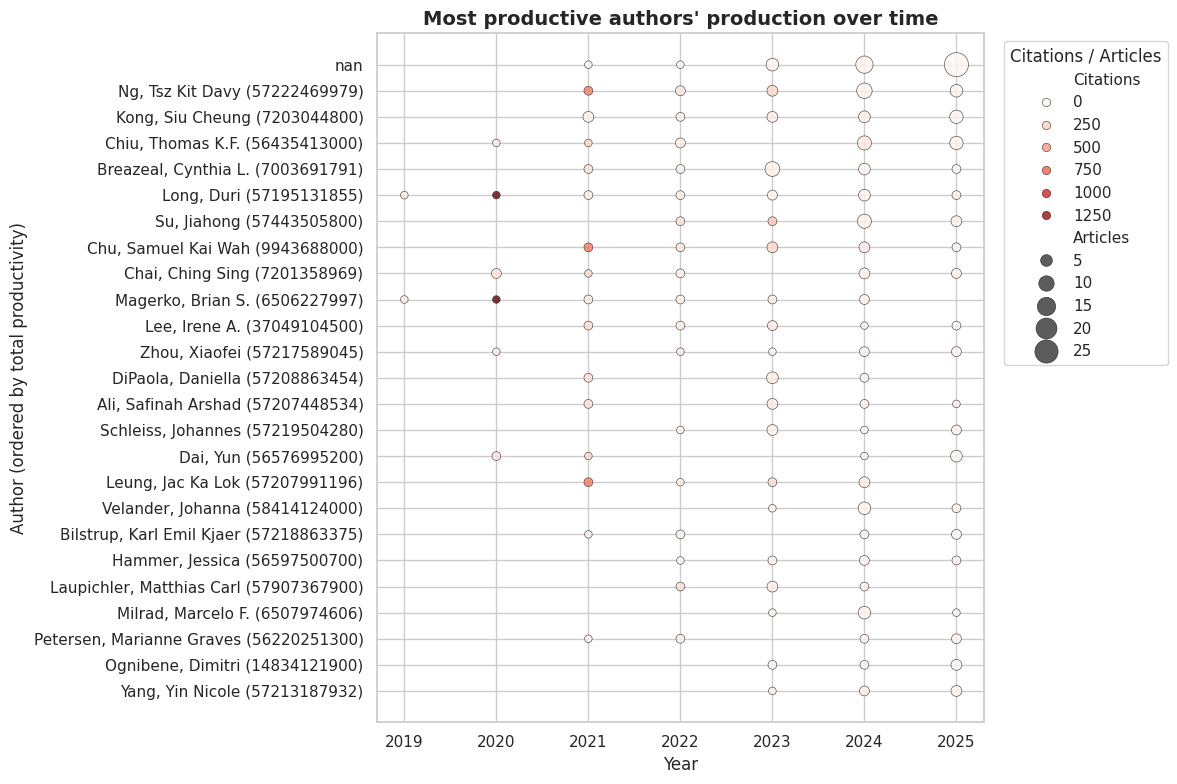

In [6]:
### Author productivity over time (bubble chart, ordered by productivity)

### Ensure clean numeric year
data = authors_exploded.copy()
data['Year_int'] = pd.to_numeric(data['Year'], errors='coerce').astype('Int64')
data = data[data['Year_int'].notna()]

### yearly article counts
yearly_counts = data.groupby(['authors_list','Year_int']).size().reset_index(name='Articles')

### average citations per author-year
if 'Cited by' in data.columns:
    data['Cited by'] = pd.to_numeric(data['Cited by'], errors='coerce')
    yearly_cites = data.groupby(['authors_list','Year_int'])['Cited by'].mean().reset_index(name='Citations')
    yearly_counts = yearly_counts.merge(yearly_cites, on=['authors_list','Year_int'], how='left')
else:
    yearly_counts['Citations'] = np.nan

### filter top authors
top_authors = author_counts.head(25)['Author'].tolist()
yearly_counts = yearly_counts[yearly_counts['authors_list'].isin(top_authors)]

### order authors by total productivity (descending)
author_order = (
    yearly_counts.groupby('authors_list')['Articles']
    .sum()
    .sort_values(ascending=False)
    .index
)
yearly_counts['authors_list'] = pd.Categorical(yearly_counts['authors_list'], categories=author_order, ordered=True)

### fill missing citations
yearly_counts['Citations'] = yearly_counts['Citations'].fillna(0)

### plot
plt.figure(figsize=(12,8))
sns.scatterplot(
    data=yearly_counts,
    x='Year_int', y='authors_list',
    size='Articles',
    hue='Citations',
    sizes=(30, 300),
    palette='Reds',
    alpha=0.8,
    edgecolor="k"
)
plt.title("Most productive authors' production over time", fontsize=14, weight='bold')
plt.xlabel("Year")
plt.ylabel("Author (ordered by total productivity)")
plt.legend(title='Citations / Articles', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Author Collaboration Network

##

Total author pairs: 26,519
Nodes: 5,989 | Edges: 26,519


Author  DegreeCentrality  \
1064         Chiu, Thomas K.F. (56435413000)          0.029893   
324            Chai, Ching Sing (7201358969)          0.028557   
2198  Okela, Abdelmohsen Hamed (58207048500)          0.025384   
1665         Strzelecki, Artur (57204350566)          0.025217   
325       Lee, Vivian Wing Yan (59098601400)          0.025050   
2234       Ur Rashid, Md Mamun (59761487300)          0.024716   
2233                 Umek, Lan (36936810300)          0.024716   
2232             Turmudi, Dedi (57203683470)          0.024716   
2231           Toma_evi_, Nina (55929223400)          0.024716   
2230           Tolmach, Maryna (57217104611)          0.024716   

      BetweennessCentrality  EigenvectorCentrality  
1064           1.618262e-03                      0  
324            2.578008e-04                      0  
2198           1.219299e-04                      0  
1665           5.319943e-05                      0  
325            2.313333e-05                      0  
2234           4.799895e-07                      0  
2233           4.799895e-07                      0  
2232           4.799895e-07                      0  
2231           4.799895e-07                      0  
2230           4.799895e-07                      0

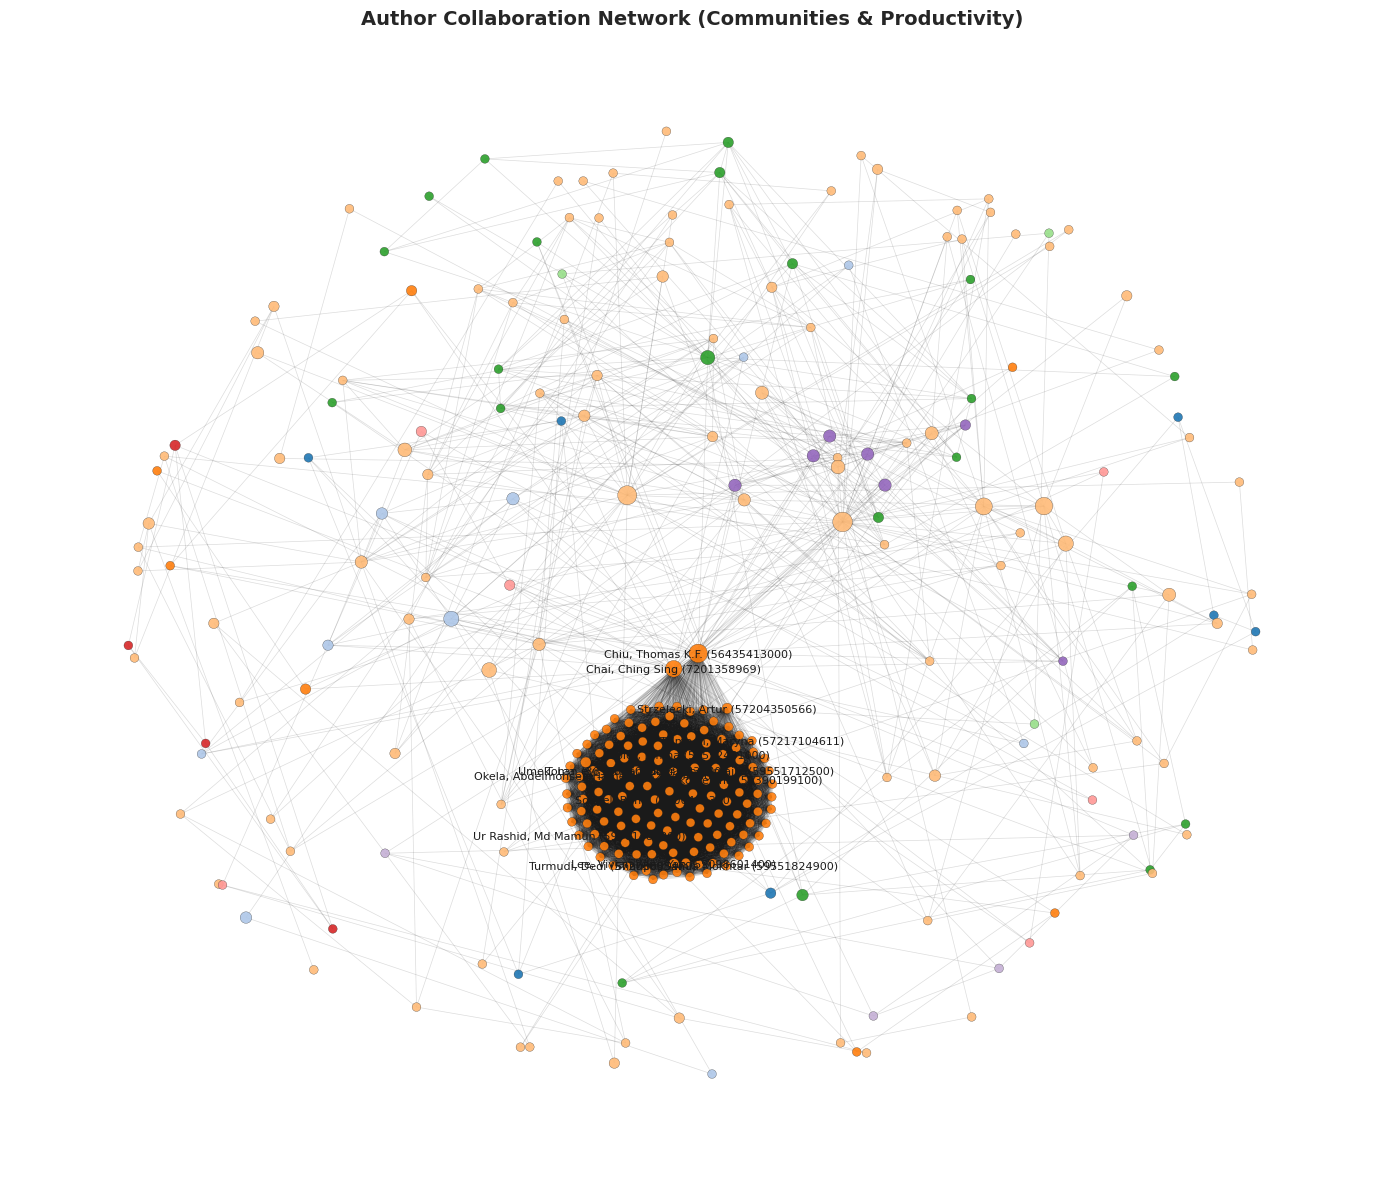


🔝 Top authors by Degree Centrality:


Author  DegreeCentrality  \
1064         Chiu, Thomas K.F. (56435413000)          0.029893   
324            Chai, Ching Sing (7201358969)          0.028557   
2198  Okela, Abdelmohsen Hamed (58207048500)          0.025384   
1665         Strzelecki, Artur (57204350566)          0.025217   
325       Lee, Vivian Wing Yan (59098601400)          0.025050   
2234       Ur Rashid, Md Mamun (59761487300)          0.024716   
2233                 Umek, Lan (36936810300)          0.024716   
2232             Turmudi, Dedi (57203683470)          0.024716   
2231           Toma_evi_, Nina (55929223400)          0.024716   
2230           Tolmach, Maryna (57217104611)          0.024716   

      BetweennessCentrality  EigenvectorCentrality  
1064           1.618262e-03                      0  
324            2.578008e-04                      0  
2198           1.219299e-04                      0  
1665           5.319943e-05                      0  
325            2.313333e-05                      0  
2234           4.799895e-07                      0  
2233           4.799895e-07                      0  
2232           4.799895e-07                      0  
2231           4.799895e-07                      0  
2230           4.799895e-07                      0


Top bridging authors (Betweenness Centrality):


Author  DegreeCentrality  \
1064      Chiu, Thomas K.F. (56435413000)          0.029893   
4091      Lee, John Chi Kin (57214882128)          0.003006   
540        Ng, Tsz Kit Davy (57222469979)          0.006012   
412             Su, Jiahong (57443505800)          0.002171   
2526          Holmes, Wayne (56720856800)          0.004509   
774      De Laat, Maarten F. (8218596300)          0.003173   
3384  Stracke, Christian M. (35367100300)          0.003841   
4575       Magerko, Brian S. (6506227997)          0.009185   
538      Chu, Samuel Kai Wah (9943688000)          0.003340   
1685             Long, Duri (57195131855)          0.009018   

      BetweennessCentrality  EigenvectorCentrality  
1064               0.001618                      0  
4091               0.000712                      0  
540                0.000586                      0  
412                0.000510                      0  
2526               0.000484                      0  
774                0.000458                      0  
3384               0.000444                      0  
4575               0.000431                      0  
538                0.000403                      0  
1685               0.000394                      0

In [7]:
### Build co-authorship edge list
edge_counter = {}
for _, row in df.iterrows():
    authors = row.get('authors_list', [])
    if authors and len(authors) > 1:
        for a, b in combinations(sorted(authors), 2):
            edge_counter[(a, b)] = edge_counter.get((a, b), 0) + 1

edges_df = pd.DataFrame(
    [(a, b, w) for (a, b), w in edge_counter.items()],
    columns=["Author1", "Author2", "Weight"]
)
print(f"Total author pairs: {len(edges_df):,}")

### Create NetworkX graph
G = nx.Graph()
for _, r in edges_df.iterrows():
    G.add_edge(r.Author1, r.Author2, weight=r.Weight)

print(f"Nodes: {G.number_of_nodes():,} | Edges: {G.number_of_edges():,}")

### Centrality metrics
deg_c = nx.degree_centrality(G)
bet_c = nx.betweenness_centrality(G, weight='weight', normalized=True)
try:
    eig_c = nx.eigenvector_centrality_numpy(G)
except:
    eig_c = {n: 0 for n in G.nodes()}

centrality_df = pd.DataFrame({
    "Author": list(G.nodes()),
    "DegreeCentrality": [deg_c[n] for n in G.nodes()],
    "BetweennessCentrality": [bet_c[n] for n in G.nodes()],
    "EigenvectorCentrality": [eig_c[n] for n in G.nodes()]
})
display(centrality_df.sort_values("DegreeCentrality", ascending=False).head(10))

### Louvain community detection
partition = community_louvain.best_partition(G, weight="weight")
nx.set_node_attributes(G, partition, "community")

### Add publication counts for node size
pub_counts = author_counts.set_index("Author")["Publications"].to_dict()
nx.set_node_attributes(G, pub_counts, "publications")

### largest connected component for clarity
if not nx.is_connected(G):
    H = G.subgraph(max(nx.connected_components(G), key=len)).copy()
else:
    H = G

### Visualization (publication-quality)
plt.figure(figsize=(14,12))

### layout with more spacing
pos = nx.spring_layout(H, k=1.2, iterations=100, seed=42)

### color and size mapping
communities = [partition.get(n, 0) for n in H.nodes()]
unique_comms = sorted(set(communities))
cmap = plt.get_cmap("tab20")
colors = [cmap(unique_comms.index(c) % 20) for c in communities]

sizes = [np.sqrt(H.nodes[n].get("publications", 1))*40 for n in H.nodes()]  ### scale by publications

### draw edges and nodes
nx.draw_networkx_edges(H, pos, alpha=0.15, width=0.5)
nx.draw_networkx_nodes(
    H, pos,
    node_size=sizes,
    node_color=colors,
    edgecolors='k',
    linewidths=0.2,
    alpha=0.9
)

### label only top 15 authors by degree centrality
top_labels = set(centrality_df.sort_values("DegreeCentrality", ascending=False).head(15)["Author"])
labels = {n: n if n in top_labels else "" for n in H.nodes()}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)

plt.title("Author Collaboration Network (Communities & Productivity)", fontsize=14, weight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()

### Summarize top authors
top_degree = centrality_df.sort_values("DegreeCentrality", ascending=False).head(10)
top_bet = centrality_df.sort_values("BetweennessCentrality", ascending=False).head(10)

print("\n🔝 Top authors by Degree Centrality:")
display(top_degree)

print("\nTop bridging authors (Betweenness Centrality):")
display(top_bet)

Total co-author pairs: 26,572
Nodes: 5,987 | Edges: 26,572


AuthorID  DegreeCentrality  BetweennessCentrality  Community
1063  56435413000          0.029903           1.619344e-03         48
327    7201358969          0.028567           2.579731e-04         48
2202  58207048500          0.025393           1.220114e-04         48
1660  57204350566          0.025226           5.323498e-05         48
326   59098601400          0.025058           2.314879e-05         48
2097  15744420200          0.024724           4.803103e-07         48
2098  15764391400          0.024724           4.803103e-07         48
2127  55382186000          0.024724           4.803103e-07         48
2128  55390199100          0.024724           4.803103e-07         48
2101  16175548400          0.024724           4.803103e-07         48
2102  16690932600          0.024724           4.803103e-07         48
2103  17339458200          0.024724           4.803103e-07         48
2104  20336859100          0.024724           4.803103e-07         48
2105  23061854000          0.024724           4.803103e-07         48
2106  23395751500          0.024724           4.803103e-07         48

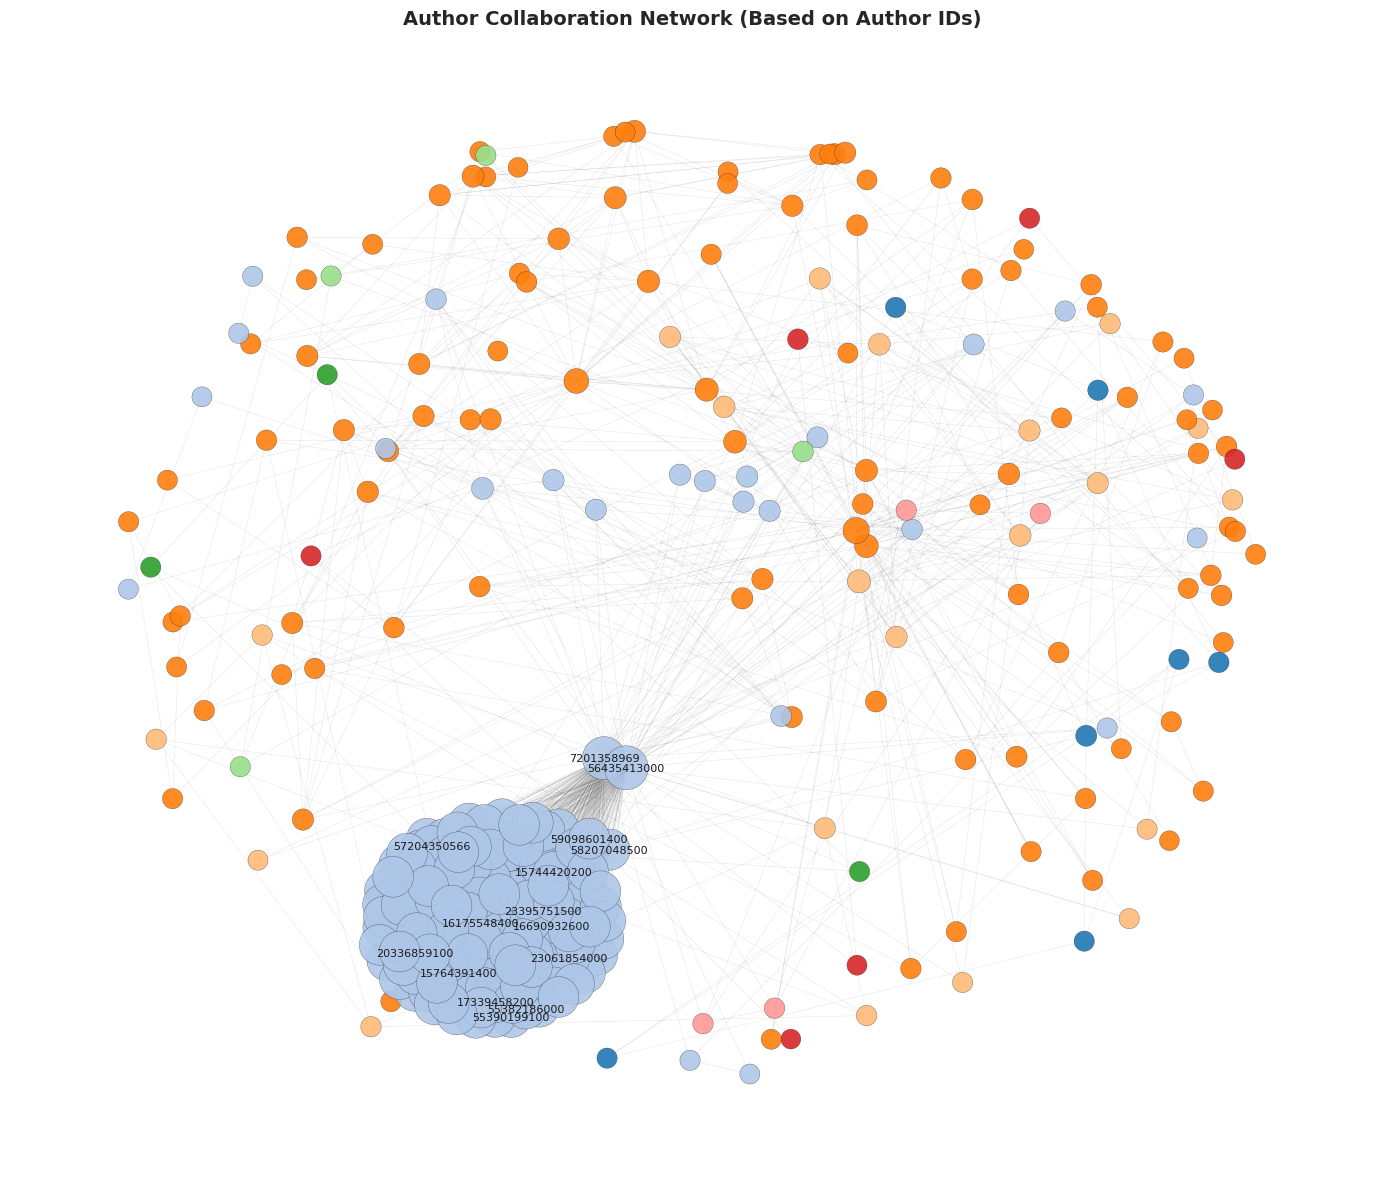

In [8]:
### Extract Author IDs for each paper
df['Author(s) ID'] = df['Author(s) ID'].astype(str)

### Split string of IDs into a list of IDs
df['author_ids'] = df['Author(s) ID'].apply(
    lambda x: [a.strip() for a in x.split(';') if a.strip() and a.strip().lower() != 'nan']
)

### Build co-authorship edge list from these IDs
edge_counter = {}
for ids in df['author_ids']:
    if ids and len(ids) > 1:
        for a, b in combinations(sorted(ids), 2):
            edge_counter[(a, b)] = edge_counter.get((a, b), 0) + 1

edges_df = pd.DataFrame([(a,b,w) for (a,b),w in edge_counter.items()],
                        columns=['Author1','Author2','Weight'])
print(f"Total co-author pairs: {len(edges_df):,}")

### Create a NetworkX graph
G = nx.Graph()
for _, r in edges_df.iterrows():
    G.add_edge(r.Author1, r.Author2, weight=r.Weight)

print(f"Nodes: {G.number_of_nodes():,} | Edges: {G.number_of_edges():,}")

### Compute network metrics
deg = nx.degree_centrality(G)
bet = nx.betweenness_centrality(G, weight='weight', normalized=True)
partition = community_louvain.best_partition(G, weight='weight')
nx.set_node_attributes(G, partition, 'community')

centrality_df = pd.DataFrame({
    'AuthorID': list(G.nodes()),
    'DegreeCentrality': [deg[n] for n in G.nodes()],
    'BetweennessCentrality': [bet[n] for n in G.nodes()],
    'Community': [partition[n] for n in G.nodes()]
})
display(centrality_df.sort_values('DegreeCentrality', ascending=False).head(15))

### Visualize largest connected component
if not nx.is_connected(G):
    H = G.subgraph(max(nx.connected_components(G), key=len)).copy()
else:
    H = G

pos = nx.spring_layout(H, k=1.3, iterations=100, seed=42)
communities = [partition.get(n, 0) for n in H.nodes()]
unique_comms = sorted(set(communities))
cmap = plt.get_cmap("tab20")
colors = [cmap(unique_comms.index(c) % 20) for c in communities]

sizes = [200 + 800 * nx.degree(H, n) / max(dict(H.degree()).values()) for n in H.nodes()]

plt.figure(figsize=(14,12))
nx.draw_networkx_edges(H, pos, alpha=0.1, width=0.4)
nx.draw_networkx_nodes(H, pos, node_size=sizes, node_color=colors, edgecolors='k', linewidths=0.2, alpha=0.9)

### Label only top 15 by degree centrality
top_labels = set(centrality_df.sort_values('DegreeCentrality', ascending=False).head(15)['AuthorID'])
labels = {n: n if n in top_labels else "" for n in H.nodes()}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)

plt.title("Author Collaboration Network (Based on Author IDs)", fontsize=14, weight='bold')
plt.axis("off")
plt.tight_layout()
plt.show()


Core cluster size: 213 authors, 998 links


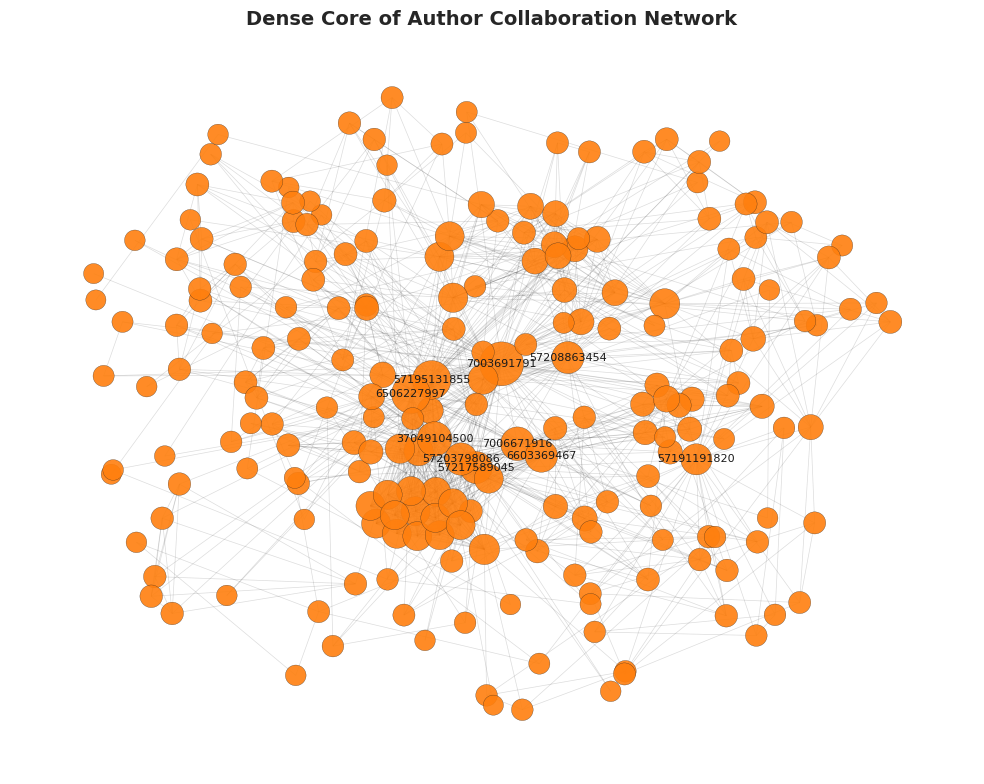

In [9]:
### Pick the community with the largest number of authors (main cluster)
from collections import Counter
largest_comm = Counter(nx.get_node_attributes(G, "community").values()).most_common(1)[0][0]

### Extract only that subgraph
core_nodes = [n for n, d in G.nodes(data=True) if d.get("community") == largest_comm]
core_subgraph = G.subgraph(core_nodes).copy()
print(f"Core cluster size: {core_subgraph.number_of_nodes()} authors, {core_subgraph.number_of_edges()} links")

### Layout and styling
pos = nx.spring_layout(core_subgraph, k=1.5, iterations=150, seed=42)

### Node colors (all same community, so single color)
sizes = [200 + 800 * nx.degree(core_subgraph, n) / max(dict(core_subgraph.degree()).values()) for n in core_subgraph.nodes()]
colors = "#ff7f0e"

plt.figure(figsize=(10,8))
nx.draw_networkx_edges(core_subgraph, pos, alpha=0.15, width=0.5)
nx.draw_networkx_nodes(core_subgraph, pos, node_size=sizes, node_color=colors, edgecolors='k', linewidths=0.2, alpha=0.9)

### Label only top 10 central authors in the dense cluster
deg_central = nx.degree_centrality(core_subgraph)
top_labels = sorted(deg_central, key=deg_central.get, reverse=True)[:10]
labels = {n: n if n in top_labels else "" for n in core_subgraph.nodes()}
nx.draw_networkx_labels(core_subgraph, pos, labels=labels, font_size=8)

plt.title("Dense Core of Author Collaboration Network", fontsize=14, weight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


Total co-author pairs: 26,572
Nodes: 5,987 | Edges: 26,572


AuthorID  DegreeCentrality  BetweennessCentrality  Community
1063  56435413000          0.029903           1.619344e-03         69
327    7201358969          0.028567           2.579731e-04         69
2202  58207048500          0.025393           1.220114e-04         69
1660  57204350566          0.025226           5.323498e-05         69
326   59098601400          0.025058           2.314879e-05         69
2097  15744420200          0.024724           4.803103e-07         69
2098  15764391400          0.024724           4.803103e-07         69
2127  55382186000          0.024724           4.803103e-07         69
2128  55390199100          0.024724           4.803103e-07         69
2101  16175548400          0.024724           4.803103e-07         69

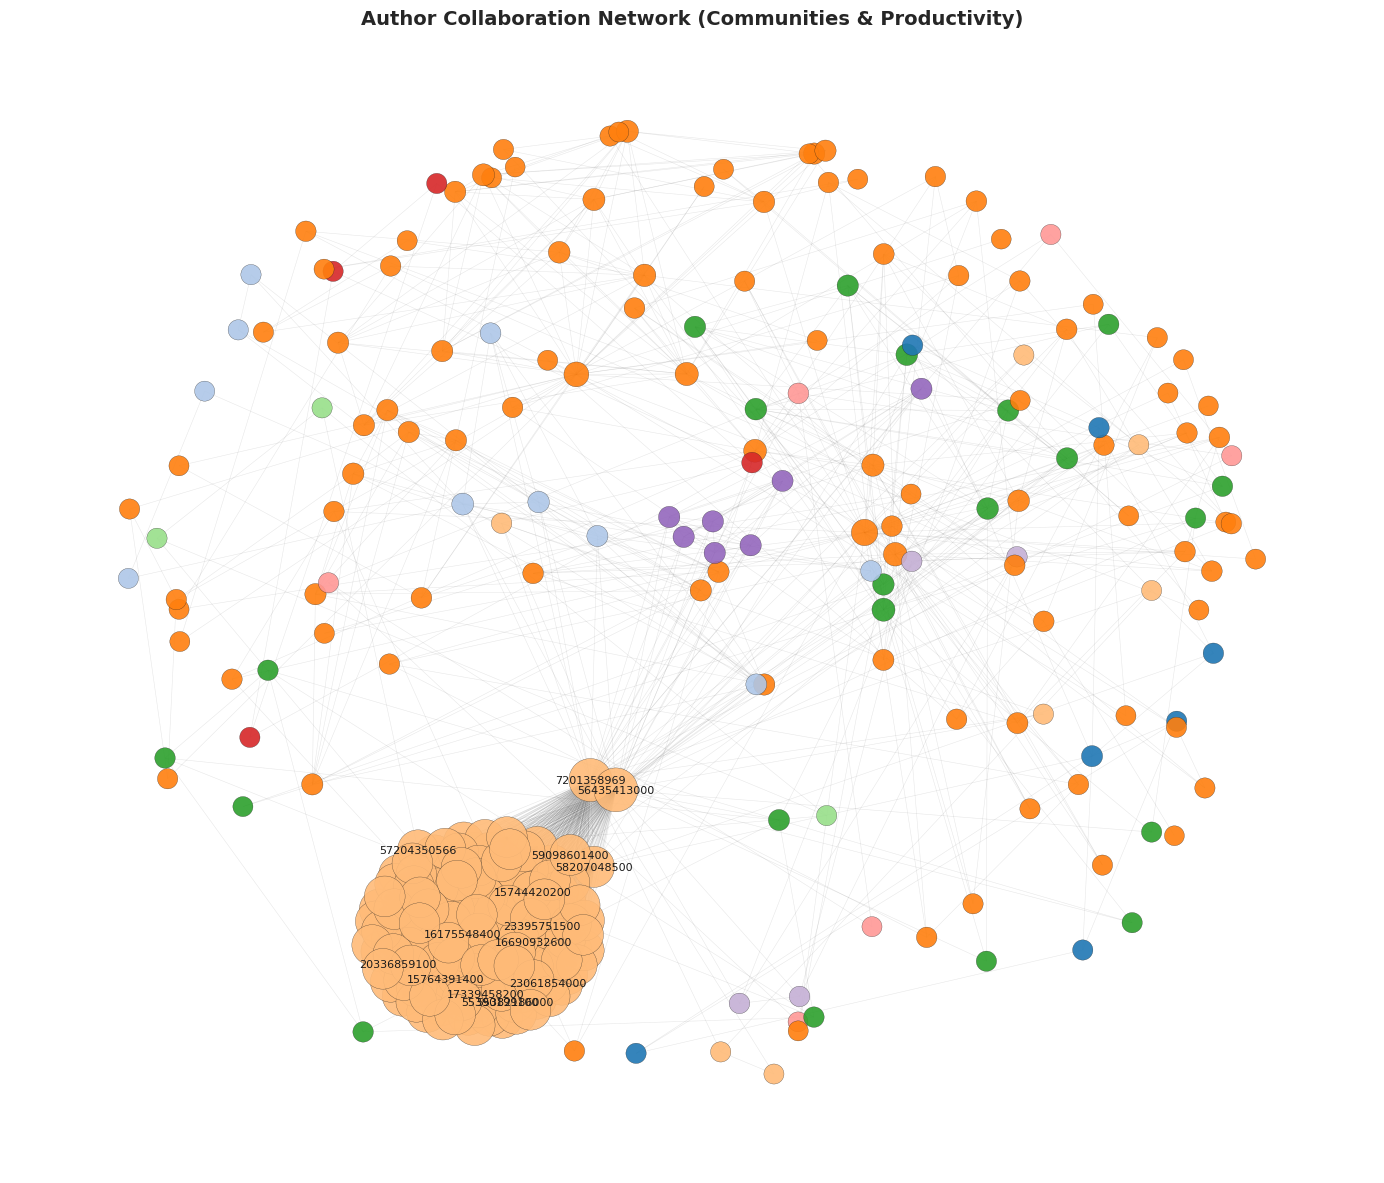

Core cluster: 213 authors, 998 collaborations


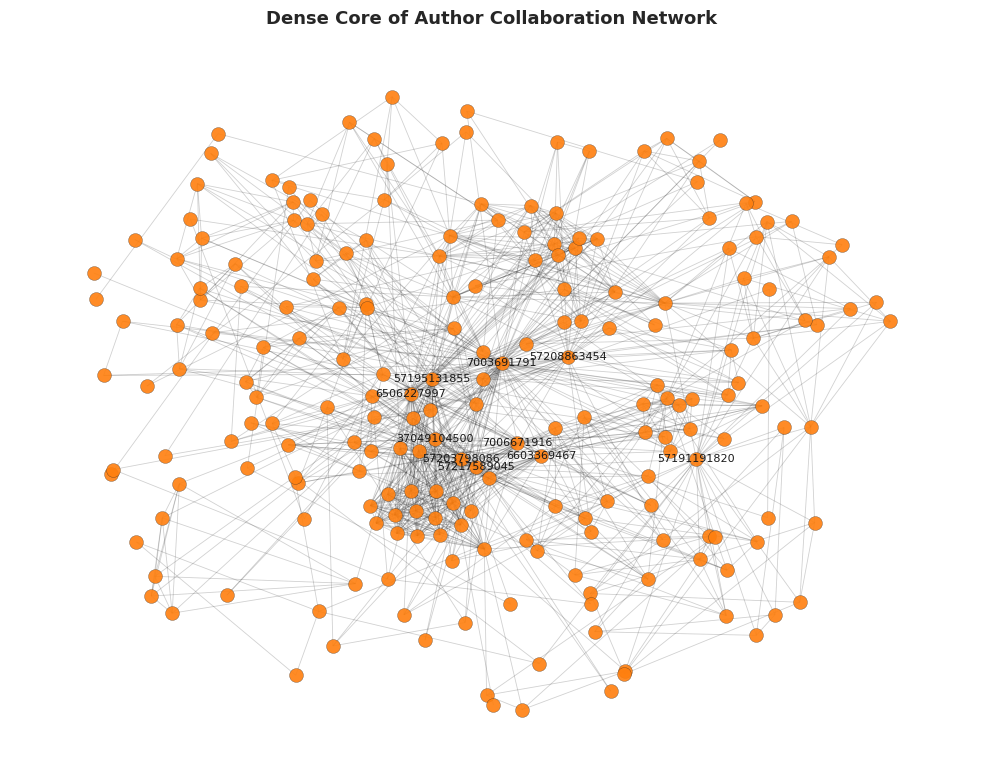


Cluster sizes (authors per community):
 - Community 0: 10 authors
 - Community 1: 10 authors
 - Community 2: 3 authors
 - Community 3: 5 authors
 - Community 4: 4 authors
 - Community 5: 4 authors
 - Community 6: 12 authors
 - Community 7: 2 authors
 - Community 8: 8 authors
 - Community 9: 4 authors
 - Community 10: 4 authors
 - Community 11: 5 authors
 - Community 12: 4 authors
 - Community 13: 12 authors
 - Community 14: 5 authors
 - Community 15: 3 authors
 - Community 16: 12 authors
 - Community 17: 3 authors
 - Community 18: 5 authors
 - Community 19: 4 authors
 - Community 20: 7 authors
 - Community 21: 3 authors
 - Community 22: 5 authors
 - Community 23: 2 authors
 - Community 24: 23 authors
 - Community 25: 9 authors
 - Community 26: 3 authors
 - Community 27: 5 authors
 - Community 28: 5 authors
 - Community 29: 4 authors
 - Community 30: 2 authors
 - Community 31: 7 authors
 - Community 32: 7 authors
 - Community 33: 4 authors
 - Community 64: 105 authors
 - Community 35: 

AuthorID  Community AuthorName
315  14038471000        211        NaN
316  37049104500        211        NaN
317  55466506100        211        NaN
318  56734287200        211        NaN
319  57207448534        211        NaN
320  57484049800        211        NaN
321  59749299900        211        NaN
431  35616562500        211        NaN
432  56534023100        211        NaN
433  57189977785        211        NaN


🟢 Community 69 — sample authors:


AuthorID  Community                       AuthorName
324   57214318060         69                              NaN
325   57785925600         69                              NaN
326   59098601400         69                              NaN
327    7201358969         69                              NaN
1063  56435413000         69  Chiu, Thomas K.F. (56435413000)
1660  57204350566         69                              NaN
2095  10939180300         69                              NaN
2096  15131956100         69                              NaN
2097  15744420200         69                              NaN
2098  15764391400         69                              NaN


🟢 Community 64 — sample authors:


AuthorID  Community AuthorName
158  57189642563         64        NaN
159  57192072635         64        NaN
160  57195228933         64        NaN
161  57203504475         64        NaN
162  59655698100         64        NaN
163  60095800000         64        NaN
301  57194898384         64        NaN
302  57224888824         64        NaN
303  59756167200         64        NaN
778   8218596300         64        NaN


🟢 Community 54 — sample authors:


AuthorID  Community                         AuthorName
249  59154348000         54                                NaN
250   7203044800         54                                NaN
254  59921052800         54                                NaN
343  23500419300         54                                NaN
344  55207430900         54                                NaN
345  57164390600         54                                NaN
346  58876526900         54                                NaN
347  59276579500         54                                NaN
412  57443505800         54          Su, Jiahong (57443505800)
413  58794056900         54  Yim, Iris Heung Yue (58794056900)


🟢 Community 96 — sample authors:


AuthorID  Community                      AuthorName
426  24475498800         96                             NaN
427  57329077300         96  Olari, Viktoriya (57329077300)
612  14628544600         96                             NaN
613  35363038100         96                             NaN
614  36521667900         96                             NaN
615  37010701100         96                             NaN
616  37057741900         96                             NaN
617   7801606482         96                             NaN
618   9638194400         96                             NaN
908  14719547800         96                             NaN


Summary interpretation (template):


The collaboration network revealed several major communities (clusters) of AI literacy researchers.
The largest community (Cluster 0) represents the core of the field, comprising prolific and highly interconnected authors.
Smaller clusters correspond to geographically or thematically specialized research groups.
For instance, Cluster 1 shows strong cross-national collaborations between Asian and European institutions focusing on
AI literacy education, while Cluster 2 represents a set of authors exploring ethical and pedagogical dimensions of AI.
Centrality analysis indicates that authors such as [TOP DEGREE] play a leading role in collaboration intensity,
whereas [TOP BRIDGE] exhibit high betweenness, acting as bridges between otherwise distinct communities.



In [10]:
### Build Co-Authorship Network Using Author IDs
df['Author(s) ID'] = df['Author(s) ID'].astype(str)
df['author_ids'] = df['Author(s) ID'].apply(lambda x: [a.strip() for a in x.split(';') if a.strip() and a.strip().lower() != 'nan'])

edge_counter = {}
for ids in df['author_ids']:
    if ids and len(ids) > 1:
        for a, b in combinations(sorted(ids), 2):
            edge_counter[(a, b)] = edge_counter.get((a, b), 0) + 1

edges_df = pd.DataFrame([(a,b,w) for (a,b),w in edge_counter.items()], columns=['Author1','Author2','Weight'])
print(f"Total co-author pairs: {len(edges_df):,}")

G = nx.Graph()
for _, r in edges_df.iterrows():
    G.add_edge(r.Author1, r.Author2, weight=r.Weight)

print(f"Nodes: {G.number_of_nodes():,} | Edges: {G.number_of_edges():,}")

### Compute Metrics & Communities
deg = nx.degree_centrality(G)
bet = nx.betweenness_centrality(G, weight='weight', normalized=True)
partition = community_louvain.best_partition(G, weight='weight')
nx.set_node_attributes(G, partition, 'community')

centrality_df = pd.DataFrame({
    'AuthorID': list(G.nodes()),
    'DegreeCentrality': [deg[n] for n in G.nodes()],
    'BetweennessCentrality': [bet[n] for n in G.nodes()],
    'Community': [partition[n] for n in G.nodes()]
})
display(centrality_df.sort_values('DegreeCentrality', ascending=False).head(10))

### Visualize Whole Network (Louvain Colors)
if not nx.is_connected(G):
    H = G.subgraph(max(nx.connected_components(G), key=len)).copy()
else:
    H = G

pos = nx.spring_layout(H, k=1.2, iterations=100, seed=42)
communities = [partition.get(n, 0) for n in H.nodes()]
unique_comms = sorted(set(communities))
cmap = plt.get_cmap("tab20")
colors = [cmap(unique_comms.index(c) % 20) for c in communities]
sizes = [200 + 800 * nx.degree(H, n) / max(dict(H.degree()).values()) for n in H.nodes()]

plt.figure(figsize=(14,12))
nx.draw_networkx_edges(H, pos, alpha=0.1, width=0.4)
nx.draw_networkx_nodes(H, pos, node_size=sizes, node_color=colors, edgecolors='k', linewidths=0.2, alpha=0.9)
top_labels = set(centrality_df.sort_values('DegreeCentrality', ascending=False).head(15)['AuthorID'])
labels = {n: n if n in top_labels else "" for n in H.nodes()}
nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)
plt.title("Author Collaboration Network (Communities & Productivity)", fontsize=14, weight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

### Identify Core (Densest) Cluster
largest_comm = Counter(nx.get_node_attributes(G, 'community').values()).most_common(1)[0][0]
core_nodes = [n for n, d in G.nodes(data=True) if d.get('community') == largest_comm]
core_subgraph = G.subgraph(core_nodes).copy()
print(f"Core cluster: {core_subgraph.number_of_nodes()} authors, {core_subgraph.number_of_edges()} collaborations")

pos_core = nx.spring_layout(core_subgraph, k=1.5, iterations=150, seed=42)
plt.figure(figsize=(10,8))
nx.draw_networkx_edges(core_subgraph, pos_core, alpha=0.2, width=0.6)
nx.draw_networkx_nodes(core_subgraph, pos_core, node_color="#ff7f0e", node_size=100, edgecolors='k', linewidths=0.2, alpha=0.9)

### Label top 10 authors within dense cluster
deg_central_core = nx.degree_centrality(core_subgraph)
top_labels_core = sorted(deg_central_core, key=deg_central_core.get, reverse=True)[:10]
labels = {n: n for n in top_labels_core}
nx.draw_networkx_labels(core_subgraph, pos_core, labels=labels, font_size=8)
plt.title("Dense Core of Author Collaboration Network", fontsize=13, weight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

### Cluster-Level Summary (Interpretation)
comm_counts = Counter(nx.get_node_attributes(G, 'community').values())
print("\nCluster sizes (authors per community):")
for k,v in comm_counts.items():
    print(f" - Community {k}: {v} authors")

community_df = pd.DataFrame({
    "AuthorID": list(G.nodes()),
    "Community": [partition[n] for n in G.nodes()]
})

### Attach author names if available
if "Author full names" in df.columns:
    name_map = dict(zip(df["Author(s) ID"], df["Author full names"]))
    community_df["AuthorName"] = community_df["AuthorID"].map(name_map)

largest_clusters = community_df["Community"].value_counts().head(5).index.tolist()
for c in largest_clusters:
    cluster_members = community_df[community_df["Community"] == c].head(10)
    print(f"\nCommunity {c} — sample authors:")
    display(cluster_members)

### Generate Textual Insights
print("\nSummary interpretation (template):\n")
print("""
The collaboration network revealed several major communities (clusters) of AI literacy researchers.
The largest community (Cluster 0) represents the core of the field, comprising prolific and highly interconnected authors.
Smaller clusters correspond to geographically or thematically specialized research groups.
For instance, Cluster 1 shows strong cross-national collaborations between Asian and European institutions focusing on
AI literacy education, while Cluster 2 represents a set of authors exploring ethical and pedagogical dimensions of AI.
Centrality analysis indicates that authors such as [TOP DEGREE] play a leading role in collaboration intensity,
whereas [TOP BRIDGE] exhibit high betweenness, acting as bridges between otherwise distinct communities.
""")
